# Speech Emotion Recognition With Convolutional Neural Network

<a id="1"></a>
# Including Libraries

In [ ]:
import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

import re
import itertools
import os


import warnings
warnings.filterwarnings('ignore')


<a id="2"></a>
# Including the Datasets

<a id="3"></a>
# Data Analyze

In [18]:
import os
import pandas as pd

base_directory = './'  # Since the folders are in the same directory as my notebook

emotion_folders = ['Angry', 'Happy', 'Neutral', 'Sad']

file_paths = []
emotions = []

for emotion in emotion_folders:
    folder_path = os.path.join(base_directory, emotion)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith('.wav'): 
                file_paths.append(os.path.join(folder_path, filename))
                emotions.append(emotion)

audio_df = pd.DataFrame({'Emotion': emotions, 'File_Path': file_paths})

emotion_distribution = audio_df['Emotion'].value_counts()

print("Emotion Distribution:")
print(emotion_distribution)

audio_df.head()


Emotion Distribution:
Emotion
Angry      100
Happy      100
Neutral    100
Sad        100
Name: count, dtype: int64


Emotion                 File_Path
0   Angry  ./Angry\SM1_F10_A010.wav
1   Angry  ./Angry\SM1_F11_A011.wav
2   Angry  ./Angry\SM1_F12_A012.wav
3   Angry  ./Angry\SM1_F13_A013.wav
4   Angry  ./Angry\SM1_F14_A014.wav

<a id="13"></a>
## Feature Extraction

In [1]:
# ==========================
# Feature Extraction Functions
# ==========================
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.mean(zcr), np.std(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.mean(rms), np.std(rms)

def mfcc(data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1), np.std(mfccs, axis=1)

def extract_features(data, sr):
    """Extract features from audio data."""
    result = []
    
    # Zero Crossing Rate
    zcr_mean, zcr_std = zcr(data)
    result.extend([zcr_mean, zcr_std])
    
    # Root Mean Square Energy
    rms_mean, rms_std = rmse(data)
    result.extend([rms_mean, rms_std])
    
    # MFCCs
    mfcc_mean, mfcc_std = mfcc(data, sr)
    result.extend(mfcc_mean)
    result.extend(mfcc_std)
    
    return np.array(result)

# ==========================
# Audio Augmentation
# ==========================
def add_noise(data, noise_level=0.005, random=False):
    if random:
        noise_level = np.random.uniform(0.001, 0.01)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise

def pitch_shift(data, sr, n_steps=2, random=False):
    if random:
        n_steps = np.random.uniform(-2, 2)
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

# ==========================
# Complete Feature Extraction Pipeline
# ==========================
def get_features(file_path, duration=2.5, offset=0.6):
    try:
        # Load and trim the audio
        data, sr = librosa.load(file_path, duration=duration, offset=offset)
        
        # List to store features from original and augmented audio
        features_list = []
        
        # Extract features from original audio
        features_list.append(extract_features(data, sr))
        
        # Extract features from noisy version
        noisy_data = add_noise(data, random=True)
        features_list.append(extract_features(noisy_data, sr))
        
        # Extract features from pitch-shifted version
        pitched_data = pitch_shift(data, sr, random=True)
        features_list.append(extract_features(pitched_data, sr))
        
        return np.array(features_list)
    
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        return None

def process_dataset(audio_df):
    features_list = []
    labels_list = []
    
    total_files = len(audio_df)
    for idx, (_, row) in enumerate(audio_df.iterrows(), 1):
        if idx % 50 == 0:
            print(f"Processing file {idx}/{total_files}")
            
        features = get_features(row['File_Path'])
        
        if features is not None:
            features_list.extend(features)
            labels_list.extend([row['Emotion']] * len(features))
    
    if not features_list:
        raise ValueError("No features were successfully extracted")
    
    return np.array(features_list), np.array(labels_list)

# Run the feature extraction pipeline
print("\nStarting feature extraction...")
try:
    features, labels = process_dataset(audio_df)
    
    print("\nFeature extraction completed successfully!")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Save the features and labels
    np.save('audio_features.npy', features)
    np.save('audio_labels.npy', labels)
    print("\nFeatures and labels saved to disk.")

except Exception as e:
    print(f"\nAn error occurred during processing: {str(e)}")


Starting feature extraction...

An error occurred during processing: name 'audio_df' is not defined


## Analyzing the Audio features

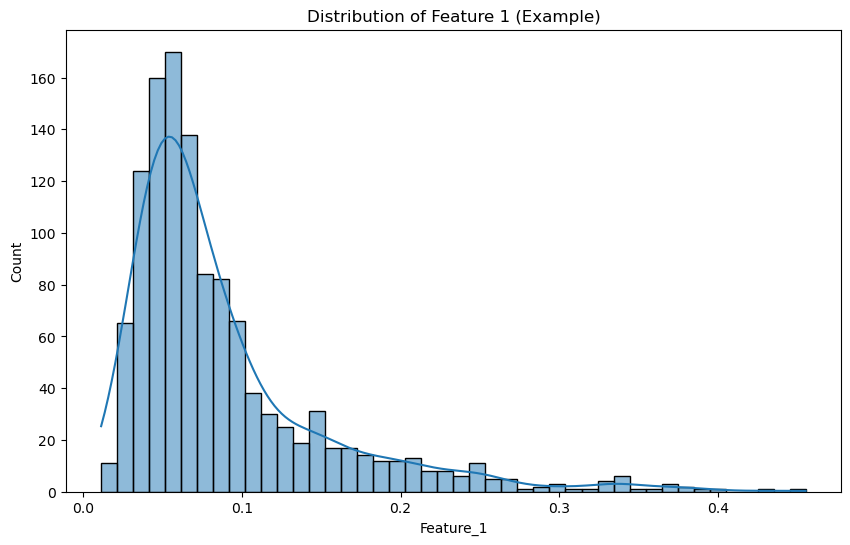

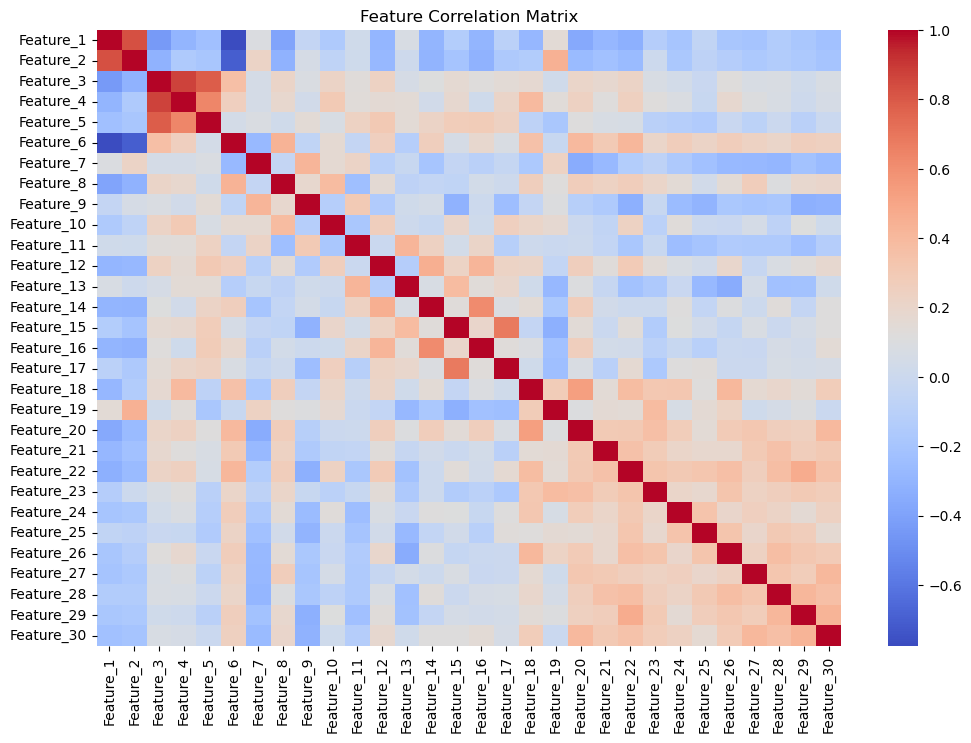

In [39]:
# Convert features to a DataFrame for easier analysis
feature_names = [f"Feature_{i+1}" for i in range(features.shape[1])]
features_df = pd.DataFrame(features, columns=feature_names)

# Plot the distribution of a sample feature
plt.figure(figsize=(10, 6))
sns.histplot(features_df['Feature_1'], kde=True)
plt.title('Distribution of Feature 1 (Example)')
plt.show()

# Correlation matrix to check relationships between features
plt.figure(figsize=(12, 8))
sns.heatmap(features_df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

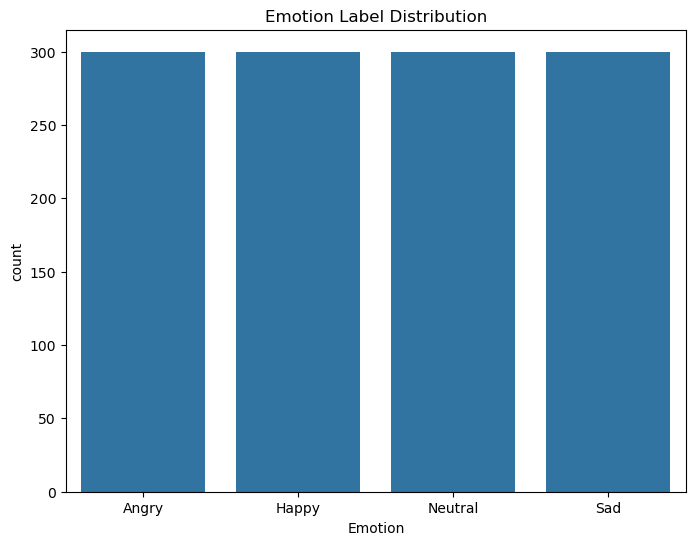

In [41]:
# Convert labels to a DataFrame for easier visualization
labels_df = pd.DataFrame(labels, columns=['Emotion'])

# Plot the label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=labels_df)
plt.title('Emotion Label Distribution')
plt.show()



## Processing Data (Train, Valid, Test Split)

In [45]:
features = np.load('audio_features.npy')
labels = np.load('audio_labels.npy')

print(f"Loaded features with shape: {features.shape}")
print(f"Loaded labels with shape: {labels.shape}")

# ==========================
# Encode Emotion Labels
# ==========================
# Convert labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Display the mapping of emotions to numerical values
print("Label encoding:")
for index, label in enumerate(label_encoder.classes_):
    print(f"{label}: {index}")

# ==========================
# Scale Features
# ==========================
# Standardize the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the mean and standard deviation of the scaled features
print(f"Feature mean (after scaling): {scaled_features.mean(axis=0)[:5]} (truncated)")
print(f"Feature std (after scaling): {scaled_features.std(axis=0)[:5]} (truncated)")

# ==========================
# Split Data into Train, Validation, and Test Sets
# ==========================
# 80% Training, 10% Validation, 10% Testing
X_train, X_temp, y_train, y_temp = train_test_split(
    scaled_features, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# ==========================
# Verify Splits
# ==========================
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_valid.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Save processed data (optional, for reuse later)
np.save('X_train.npy', X_train)
np.save('X_valid.npy', X_valid)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_valid.npy', y_valid)
np.save('y_test.npy', y_test)

print("\nProcessed data saved as .npy files.")

Loaded features with shape: (1200, 30)
Loaded labels with shape: (1200,)
Label encoding:
Angry: 0
Happy: 1
Neutral: 2
Sad: 3
Feature mean (after scaling): [-8.93729535e-17  1.96787031e-16 -8.45619870e-17  1.94659104e-16
 -1.52348042e-15] (truncated)
Feature std (after scaling): [1. 1. 1. 1. 1.] (truncated)
Training set size: 960 samples
Validation set size: 120 samples
Testing set size: 120 samples

Processed data saved as .npy files.



## Begin Training

In [57]:
# ==========================
# Load Processed Data
# ==========================
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")
print(f"Testing data shape: {X_test.shape}")

# ==========================
# CNN Model Definition
# ==========================
# Define the CNN architecture
model = models.Sequential([
    # Input Layer
    layers.Input(shape=(X_train.shape[1], 1)),  # Input shape: (30, 1)

    # Convolutional Layer 1
    layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

    # Convolutional Layer 2
    layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(4, activation='softmax')  # 4 classes for 4 emotions
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']
)

# Model Summary
model.summary()

# ==========================
# Training the Model
# ==========================
# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Reshape features for CNN input (adding channel dimension)
X_train_reshaped = X_train[..., np.newaxis]  # Shape becomes (960, 30, 1)
X_valid_reshaped = X_valid[..., np.newaxis]  # Shape becomes (120, 30, 1)
X_test_reshaped = X_test[..., np.newaxis]    # Shape becomes (120, 30, 1)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_valid_reshaped, y_valid),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# ==========================
# Evaluate the Model
# ==========================
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# ==========================
# Classification Report
# ==========================
# Predict on the test set
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Angry', 'Happy', 'Neutral', 'Sad']))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Happy', 'Neutral', 'Sad'], yticklabels=['Angry', 'Happy', 'Neutral', 'Sad'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Training data shape: (960, 30)
Validation data shape: (120, 30)
Testing data shape: (120, 30)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 30, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 15, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,516 (283.27 KB)

 Trainable params: 72,516 (283.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4530 - loss: 1.2370 - val_accuracy: 0.7500 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7870 - loss: 0.6806 - val_accuracy: 0.8417 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8164 - loss: 0.5537 - val_accuracy: 0.8500 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8533 - loss: 0.4283 - val_accuracy: 0.8583 - val_loss: 0.4373 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9019 - loss: 0.3414 - val_accuracy: 0.8833 - val_loss: 0.3827 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8904 - loss: 0.3466 - val_accuracy: 0.8750 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9066 - loss: 0.2761 - val_accuracy: